In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import math
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [3]:
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
adidas_dir = image_dir + 'adidas/'
img_file = adidas_dir + os.listdir(adidas_dir)[0]

# Load adidas template
ref_dir = base_dir + 'data/logo_references/adidas/'
ref_file = ref_dir + os.listdir(ref_dir)[0] 

In [8]:
# read grayscale image with intensity range between 0-1
def read_image(in_path):

    img = plt.imread(in_path)
    
    # floating point image with intensity [0, 1]
    if np.max(img) > 1:
        img = img.astype(np.float32) / 255.0
    
    # convert to grayscale
    if len(img.shape) > 2:
        img = img[:, :, 2].copy()
        
    return img

In [9]:
 # IMAGES
im = read_image(img_file)
ref = read_image(ref_file)

In [10]:
# input a grayscale image and draw keypoints
def drawKeyPts(grayImage, keyp):
    
    out_im = (grayImage * 255).astype(np.uint8)
    out_im = np.concatenate((out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis], 
                             out_im[:,:,np.newaxis]), axis=2)
    
    for curKey in keyp:
        x=np.int32(curKey.pt[0])
        y=np.int32(curKey.pt[1])
        size = np.int32(curKey.size)
        cv2.circle(out_im, (x,y), 8, [255, 0, 0], 
                   thickness=1, lineType=8, shift=0)

    return out_im
    

# compute the key points from input grayscale images
def HarrisKeypointDetector(in_image, n=2, w=3, k=0.04, verbose=True):
    
    # STEP 1:
    # compute the points where there are good corners in the image
    # the score for good corners are computed as follows:
    # harrisImage = det(H) - k(trace(H))^2
    # where H = A.T*A seen in the async lecture
    
    # parameters to cv2.cornerHarris are:
    #   grayscale image
    #   n = size of the window to compute the A
    #   w = size of the kernel to compute the gradients
    #   k = value for k in det(H) - k(trace(H))^2
    harrisImage = cv2.cornerHarris(in_image, n, w, k)
    
    # STEP 2:
    # threshold the scores to keep only interesting features
    thresh = 0.1 * harrisImage.max()
    harrisMaxImage = harrisImage > thresh
    
    # STEP 3:
    # get keypoints structure from the detected features
    height, width = in_image.shape[:2]
    features = []
    for y in range(height):
        for x in range(width):
            
            # do not include if it is not in the good features
            if not harrisMaxImage[y, x]:
                continue

            # fill in the parameters
            f = cv2.KeyPoint()
            f.pt = (x, y)
            f.response = harrisImage[y,x]
            features.append(f)

    if verbose:
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,7))
        ax[0].imshow(drawKeyPts(in_image, features)); ax[0].axis('off')
        ax[0].set_title('image')
        har_im = ax[1].imshow(harrisImage, cmap='gray'); ax[1].axis('off')
        # create an axes on the right side of ax. The width of cax will be 5%
        # of ax and the padding between cax and ax will be fixed at 0.05 inch.
        divider = make_axes_locatable(ax[1])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(har_im, cax=cax)
        ax[1].set_title('score')
        plt.suptitle('KEYPOINTS')
        plt.show()
            
    return features



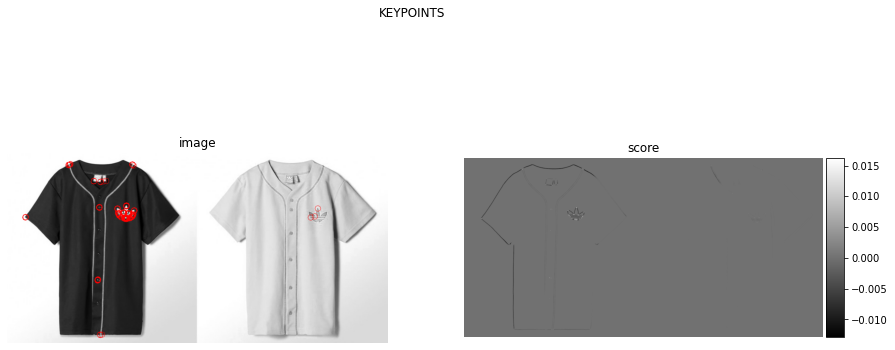

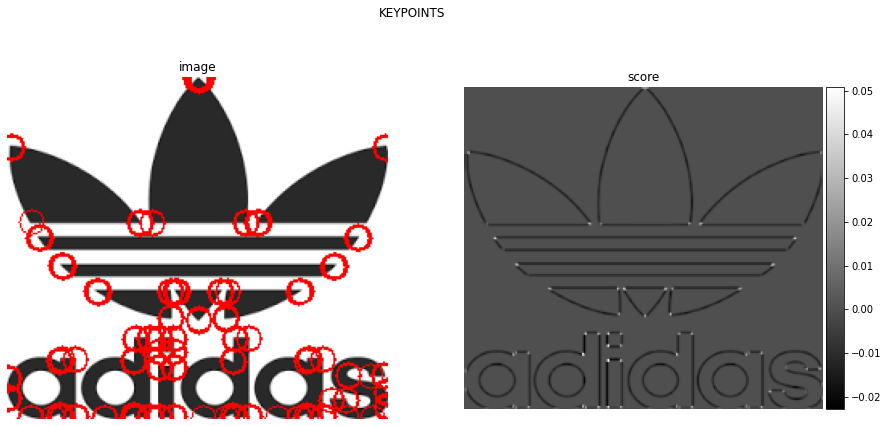

In [24]:
# detect the features
kp1 = HarrisKeypointDetector(im, n=2)
kp2 = HarrisKeypointDetector(ref, n=2)

In [53]:
# get simple feature detector with only pixel values around wxw window
def SimpleFeatureDescriptor(grayImage, keypoints, w=5):
    
    # for every keypoint get the pixel values around 5x5 window
    grayImage1 = np.pad(grayImage, [(w,w), (w,w)], mode='constant')
    desc = np.zeros((len(keypoints), w*w), np.float32)

    for i, f in enumerate(keypoints):
        x, y = f.pt
        x, y = np.int32(x), np.int32(y)
        x=x+w
        y=y+w

        each_desc = grayImage1[y - w//2 : y + w//2 + 1, 
                               x - w//2 : x + w//2 + 1].reshape([1, w*w])
        desc[i, :] = each_desc

    return desc

# more robust feature descriptor using ORB
def ORBFeatureDescriptor(grayImage, keypoints):
    #orb = cv2.ORB_create() # 
    orb = cv2.SIFT_create() #
    kp, des = orb.compute((grayImage * 255).astype(np.uint8), keypoints)
    return des

In [77]:
# describe features
desc1 = SimpleFeatureDescriptor(im, kp1, w=5)
desc2 = SimpleFeatureDescriptor(ref, kp2, w=5)

#desc1 = ORBFeatureDescriptor(im, kp1)
#desc2 = ORBFeatureDescriptor(ref, kp2)

In [85]:
# match the input feature descriptors using a simple brute force search
def feature_matching(desc1, desc2):
    
    # BFMatcher with default params
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(desc1, desc2, k=2)

    # store all the good matches as per Lowe's ratio test.
    good = []
    for m,n in matches:
        if m.distance < 0.7*n.distance:
            good.append(m)
    
    return good

In [89]:

# match good features
good_matches = feature_matching(desc1, desc2)

fig, ax = plt.subplots(2, len(good_matches), figsize=(10, 10))
for i in range(len(good_matches)):
    ref_pt = kp1[m.queryIdx]
    im_pt = kp2[m.trainIdx]
    ax[i, 0].imshow(ref)
    ax[i, 1].imshow(im)


12

In [95]:
print(kp1[12].pt)
print(kp2[140].pt)

(233.0, 78.0)
(212.0, 186.0)


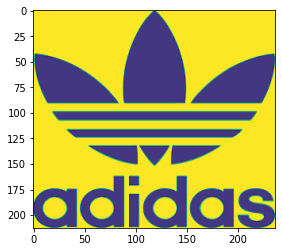

In [96]:
plt.imshow(ref)

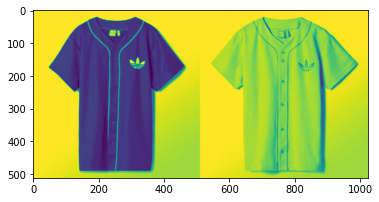

In [98]:
plt.imshow(im)

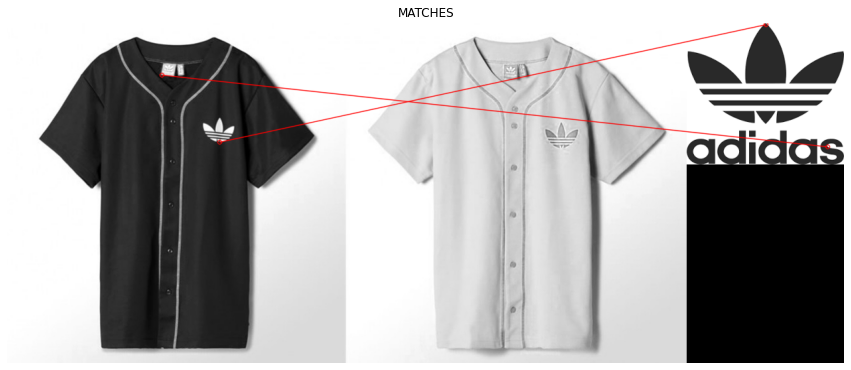

In [87]:
# display the matches
draw_params = dict(matchColor = (255, 0, 0), # draw matches in green
                    singlePointColor = None, # draw only inliers
                    flags = 2)

match_img = cv2.drawMatches((im*255).astype(np.uint8), kp1, 
                            (ref*255).astype(np.uint8), kp2, 
                            good_matches, None, **draw_params)

fig = plt.figure(figsize=(15,7))
plt.imshow(match_img)
plt.axis('off')
plt.title('MATCHES')
plt.show()